# Median-based hypothesis testing

In [39]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [40]:
def median_hyphotesis_test(shuffled_results_list, empirical_result):
    """
    Calculate the empirical p-value based on a list of shuffled (simulated) results and an actual empirical result.
    
    The function compares the empirical result against the distribution of shuffled results to determine
    how extreme the empirical result is within that distribution. It calculates the p-value as the proportion
    of shuffled results more extreme than the empirical result, depending on its direction relative to the median.
    
    Parameters:
    - shuffled_results_list (list or np.array): The distribution of results from shuffled or simulated data.
    - empirical_result (float): The result obtained from the actual data for comparison.
    
    Returns:
    - str: A string representing the p-value, prefixed with '+' or '-' indicating whether the empirical result
      is above or below the median of the shuffled results, respectively. If the empirical result is equal to the
      median, it chooses the direction with a higher p-value. If counts of lower and higher are equal, returns '1'.

    """
    # Compare empirical result to median of shuffled results
    if empirical_result < np.median(shuffled_results_list):
        higher_values_count = 0
        # Count how many shuffled results are greater than the empirical result
        for single_shuffle_result in shuffled_results_list:
            if single_shuffle_result > empirical_result:
                higher_values_count += 1
        # Calculate p-value
        p_value = 1 - higher_values_count / len(shuffled_results_list)
        # Return p-value with '-' indicating below median
        return '-' + str(np.round(p_value, 3))

    elif empirical_result > np.median(shuffled_results_list):
        lower_values_count = 0
        # Count how many shuffled results are less than the empirical result
        for single_shuffle_result in shuffled_results_list:
            if single_shuffle_result < empirical_result:
                lower_values_count += 1
        # Calculate p-value
        p_value = 1 - lower_values_count / len(shuffled_results_list)
        # Return p-value with '+' indicating above median
        return '+' + str(np.round(p_value, 3))

    else:  # empirical_result == np.median(shuffled_results_list)
        lower_values_count = 0
        higher_values_count = 0
        # Count how many shuffled results are less and more than the empirical result
        for single_shuffle_result in shuffled_results_list:
            if single_shuffle_result < empirical_result:
                lower_values_count += 1
            elif single_shuffle_result > empirical_result:
                higher_values_count += 1
        # Calculate p-values for both directions
        p_value_right = 1 - lower_values_count / len(shuffled_results_list)
        p_value_left = 1 - higher_values_count / len(shuffled_results_list)
        # Determine and return the p-value with larger absolute value
        if lower_values_count == higher_values_count:
            return '1'  # Return '1' if counts are equal, indicating no bias
        elif abs(p_value_right) >= abs(p_value_left):
            return '+' + str(np.round(p_value_right, 3))
        else:
            return '-' + str(np.round(p_value_left, 3))

In [41]:
print('The empirical p-value (comparing the empirical value to the shuffled distribution) is:',median_hyphotesis_test([1, 2, 3, 4, 5], 3))
print('The empirical p-value (comparing the empirical value to the shuffled distribution) is:',median_hyphotesis_test([1, 2, 3, 4, 5], 2.5))
print('The empirical p-value (comparing the empirical value to the shuffled distribution) is:',median_hyphotesis_test([1, 2, 3, 4, 5], 3.5))

The empirical p-value (comparing the empirical value to the shuffled distribution) is: 1
The empirical p-value (comparing the empirical value to the shuffled distribution) is: -0.4
The empirical p-value (comparing the empirical value to the shuffled distribution) is: +0.4


# Example: Calls data

In [42]:
# Loading the original data
with open('calls_ijt.pickle', 'rb') as handle:
    data = pickle.load(handle)
df_edges_calls = pd.DataFrame(data, columns = ['from', 'to', 't_second'])
df_edges_calls 

,from,to,t_second
0,300,301,184
1,512,299,3920
2,301,300,5623
3,401,457,9252
4,512,0,15466
...,...,...,...
3595,706,401,2414934
3596,218,382,2415585
3597,561,631,2416059
3598,323,392,2416368


In [43]:
# Loading the original (empirical) measure values and other properties of the network
infile = open('original_results.pkl','rb')
dictionary_list_1 = pickle.load(infile)
original_measures =  dictionary_list_1[0][5]
original_measures

,P(E_rec),P(l_rec),B_edges,Nber_events,Nber_links
data,,,,,
Calls,0.451446,0.97093,0.220992,2624.0,172


In [44]:
# Loading measures P(E_rec) and P(l_rec) computed on the shuffled data
# These measures describe the reciprocity on the event and link level
with open('shuffled_calls_measures.pkl', 'rb') as handle:
    dictionary_list = pickle.load(handle)
print('Number of samples',len(dictionary_list[0][1]))

Number of samples 50


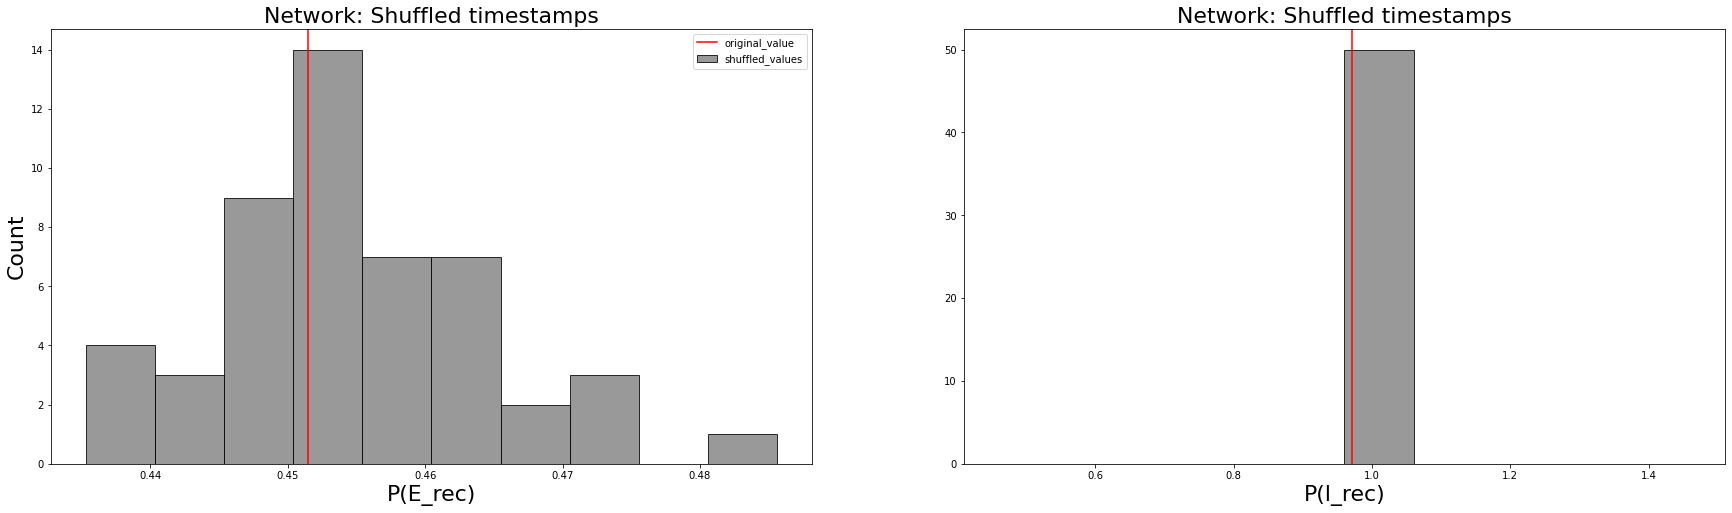

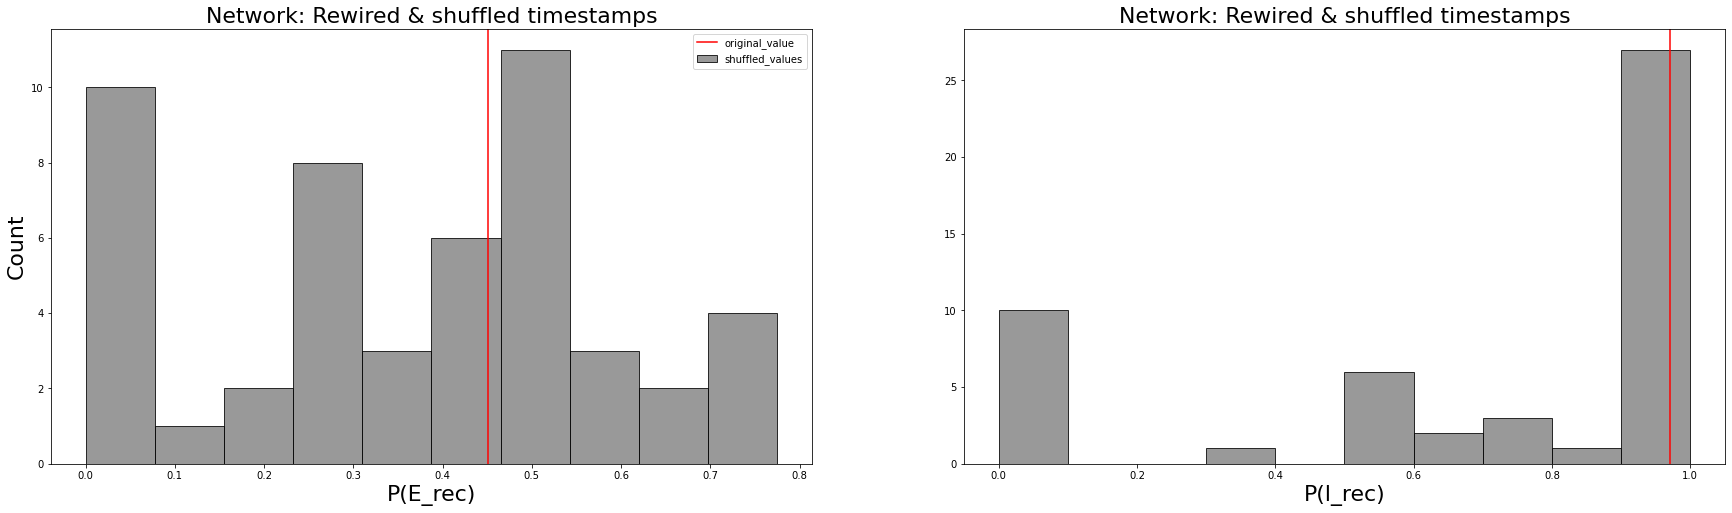

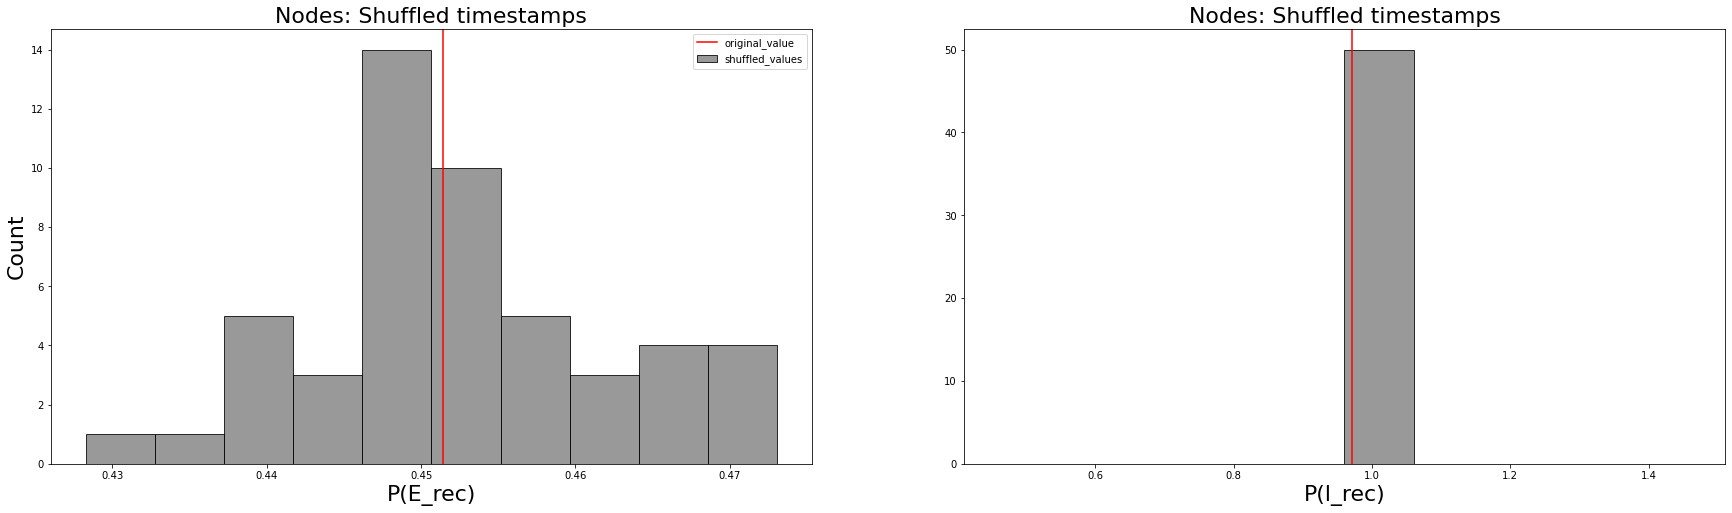

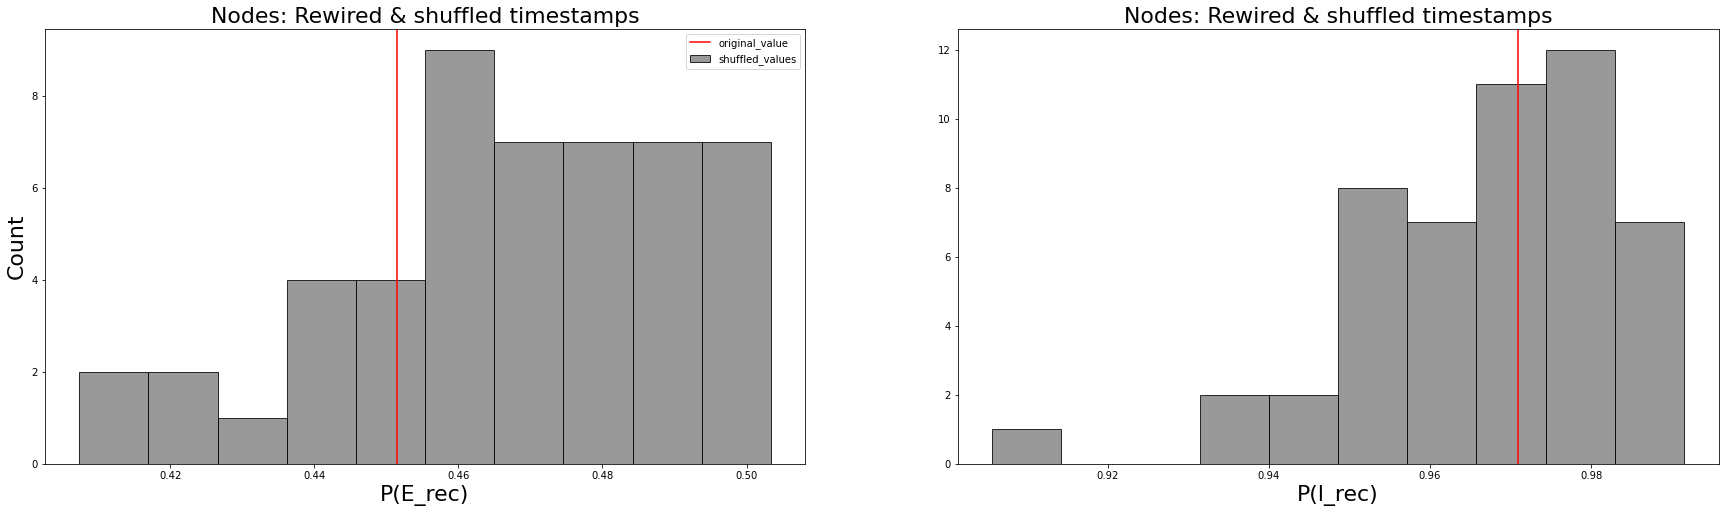

In [76]:
# Define titles for each shuffle method
shuffle_titles = {
    1: 'Network: Shuffled timestamps',
    2: 'Network: Rewired & shuffled timestamps',
    3: 'Nodes: Shuffled timestamps',
    4: 'Nodes: Rewired & shuffled timestamps',
    5: 'Links: Shuffled timestamps'
}

# Initialize dictionaries to store p-values and mean values
p_values_dict = {}
mean_values_dict = {}

# Iterate through methods, excluding 'Links: Shuffled timestamps'
for method in range(1, 5):
    # Initialize dictionaries for the current method
    p_values_dict[shuffle_titles[method]] = {}
    mean_values_dict[shuffle_titles[method]] = {}
    
    # Extract data lists from dictionary_list using current method
    E_rec_list, l_rec_list = dictionary_list[0][method], dictionary_list[1][method]
    
    # Calculate and plot P(E_rec)
    fig = plt.figure(figsize=(30, 8))
    original_e_rec = original_measures['P(E_rec)'][0]  # Get original P(E_rec)
    E_rec_list = np.where(np.isnan(E_rec_list), 0, E_rec_list)  # Replace NaNs with 0s
    
    # Calculate and store P(E_rec) p-value and mean
    p_values_dict[shuffle_titles[method]]['P(E_rec)'] = empirical_p_value(E_rec_list, original_e_rec)
    mean_values_dict[shuffle_titles[method]]['P(E_rec)'] = np.nanmean(E_rec_list)
    plt.subplot(1, 2, 1)  # First subplot for P(E_rec)
    plt.hist(E_rec_list,edgecolor='black',color='gray',alpha=0.8,label='shuffled_values') # Histogram of E_rec_list
    plt.axvline(original_e_rec, color='red',label='original_value')  # Original P(E_rec) line
    plt.xlabel('P(E_rec)', fontsize=22)
    plt.ylabel('Count', fontsize=22)
    plt.title(shuffle_titles[method], fontsize=22)
    plt.legend()

    # Calculate and plot P(l_rec)
    original_l_rec = original_measures['P(l_rec)'][0]  # Get original P(l_rec)
    l_rec_list = np.where(np.isnan(l_rec_list), 0, l_rec_list)  # Replace NaNs with 0s
    # Calculate and store P(l_rec) p-value and mean
    p_values_dict[shuffle_titles[method]]['P(l_rec)'] = empirical_p_value(l_rec_list, original_l_rec)
    mean_values_dict[shuffle_titles[method]]['P(l_rec)'] = np.nanmean(l_rec_list)
    plt.subplot(1, 2, 2)  # Second subplot for P(l_rec)
    plt.hist(l_rec_list,color='gray',alpha=0.8,edgecolor='black',label='shuffled_values')  # Histogram of l_rec_list
    plt.axvline(original_l_rec, color='red',label='original_value')   # Original P(l_rec) line
    plt.xlabel('P(l_rec)', fontsize=22)
    plt.title(shuffle_titles[method], fontsize=22)


In [70]:
#These results were used in the research article
final_p_score_table = pd.concat([
    pd.DataFrame(p_values_dict[key.strip()], index=[key.strip()])
    for key in [
        'Network: Shuffled timestamps',
        'Nodes: Shuffled timestamps',
        'Network: Rewired & shuffled timestamps',
        'Nodes: Rewired & shuffled timestamps'
    ]
]).rename(index=str.strip).loc[:, ['P(E_rec)', 'P(l_rec)']].round(2).transpose()
final_p_score_table.index.name = "Calls"
final_p_score_table

,Network: Shuffled timestamps,Nodes: Shuffled timestamps,Network: Rewired & shuffled timestamps,Nodes: Rewired & shuffled timestamps
Calls,,,,
P(E_rec),-0.4,+0.48,+0.42,-0.18
P(l_rec),+0.0,+0.0,-0.46,+0.46
